In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
distortion_coefficients = np.array([-0.0054, 0.0506, -0.0505, 0.0103])
focal_length = np.array([288.6819, 284.8705])
principal_point = np.array([420.2098, 402.7797])
image_size = np.array([848, 800])

In [3]:
#generate mesh grid
n = 8
scale = 50
x = np.arange(int(image_size[0] / scale))
y = np.arange(int(image_size[1] / scale))
# 3×3の格子点を作成
X, Y = np.meshgrid(x, y)
pt = np.c_[X.ravel(), Y.ravel()].T * scale

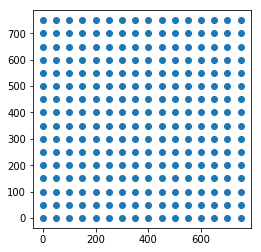

In [4]:
im = plt.subplot()
im.set_aspect('equal')
im.scatter(pt[0], pt[1])

### undistortion
\begin{eqnarray}
x_d &=& \frac{u_d - c_x}{f_x} \\
y_d &=& \frac{u_d - c_y}{f_y} \\
r^2 &=& x^2 + y^2 \\
\theta &=& arctan(r, 1) \\
\theta_d &=& \theta(1 + k_1 \theta^2 + k_2 \theta^4 + k_3 \theta^6 + k_4 \theta^8)\\
x &=& \frac{\theta_d x_d}{r} \\
y &=& \frac{\theta_d y_d}{r} \\
u &=& \hat{f_x} x + \hat{c_x} \\
v &=& \hat{f_y} y + \hat{c_y}
\end{eqnarray}

### distortion (Solve a polynomial)
\begin{eqnarray}
x &=& \frac{u - c_x}{f_x} \\
y &=& \frac{u - c_y}{f_y} \\
r^2 &=& x^2 + y^2
\end{eqnarray}

calcrate eigenvalues of companion matrix 
\begin{eqnarray}
C = 
\left[
\begin{array}{ccccccccc}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \frac{r}{k_4}\\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -\frac{1.0}{k_4}\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & -\frac{k_1}{k_4}\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & -\frac{k_2}{k_4}\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & -\frac{k_3}{k_4}\\ 
0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 0
\end{array}
\right]
\end{eqnarray}

\begin{eqnarray}
\theta &=& \mathrm{eigen values of} C \\
\phi &=& arctan2(y, x) \\
p_x &=& sin(\theta)sin(\phi) \\
p_y &=& sin(\theta)cos(\phi) \\
p_z &=& cos(\theta) \\
\bar{x} &=& \frac{p_x}{p_z} \\
\bar{y} &=& \frac{p_y}{p_z} \\
u_d &=& f_x \bar{x} + c_x \\
v_d &=& f_y \bar{y} + c_y
\end{eqnarray}

In [5]:
def normalize(focal_length, principal_point, pt):
    return (pt - principal_point.reshape(2,1)) / focal_length.reshape(2,1)

def denormalize(focal_length, principal_point, uv):
    return uv * focal_length.reshape(2,1) + principal_point.reshape(2,1)

def distortion(dist, pts):
    k1 = dist[0]
    k2 = dist[1]
    k3 = dist[2]
    k4 = dist[3]
    x = pts[0]
    y = pts[1]
    xx = x * x
    yy = y * y
    r = np.sqrt(xx + yy)
    theta = np.arctan2(r, 1)    
    theta2 = theta * theta
    theta4 = theta2 * theta2
    theta6 = theta2 + theta4
    theta8 = theta4 * theta4
    thetad = theta * (1 + k1 * theta2 + k2 * theta4 + k3 * theta6 + k4 * theta8)
    scaling = np.where(r > 1e-8, thetad / r, 1.0)
    return thetad / r * pts

def undistortion(dist, duv):
    tol = 1e-10
    duv_norm = np.sqrt(duv[0] * duv[0] + duv[1] * duv[1])
    num_elm = duv_norm.shape[0]
    ray = np.zeros(duv.shape)
    for i in range(num_elm):
        if(duv_norm[i] < 1e-10):
            phi = 0.0
        else:
            phi = np.arctan2(duv[1,i], duv[0,i])
        # estimate theta by companin matrix
        coeffs = np.array([-duv_norm[i], 1.0, 0, dist[0], 0, dist[1], 0, dist[2], 0, dist[3]]) / dist[3]
        A = np.zeros([9,9])
        A[1:9,0:8] = np.eye(8)
        A[:,-1] = - coeffs[0:9]
        eigen, _ = np.linalg.eig(A)
        eigen = eigen.real[np.abs(eigen.imag) < tol]
        eigen = eigen[eigen > -tol]
        eigen = np.where(eigen < 0, 0.0, eigen)
        
        if(eigen.shape[0] == 0):
            theta = duv_norm[i]
        else:
            theta = np.min(eigen)
            
        P0 = np.sin(theta) * np.cos(phi)
        P1 = np.sin(theta) * np.sin(phi)
        P2 = np.cos(theta)
    
        ray[:,i] = np.array([P0, P1]) / P2
    return ray
    
    #mx_u = distortion(distortion_coefficients, duv)
    #for i in range(n):
    #    mx_u = duv - distortion(distortion_coefficients, mx_u)
    #return mx_u
    

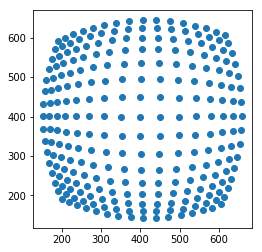

In [6]:
uv = normalize(focal_length, principal_point, pt)
duv = distortion(distortion_coefficients, uv)
dpt = denormalize(focal_length, principal_point, duv)

im = plt.subplot()
im.set_aspect('equal')
im.scatter(dpt[0], dpt[1])

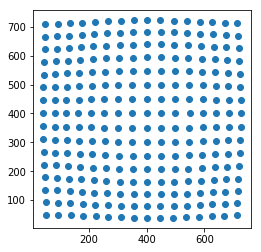

In [7]:
e_uv = undistortion(distortion_coefficients, duv)
ept = denormalize(focal_length, principal_point, e_uv)

im = plt.subplot()
im.set_aspect('equal')
im.scatter(ept[0], ept[1])

In [8]:
def norm(pt):
    return np.sqrt(pt[0] * pt[0] + pt[1] * pt[1])

np.max(norm(pt - ept))

69.8792602445736